# Exploratory data analysis

# Purpose
Explore the data and extend/transform features.

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import sympy as sp

import pandas as pd
import numpy as np

# Unmark for publish quality plots
#if os.name == 'nt':
#    plt.style.use('paper.mplstyle')  # Windows

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.integrate import solve_ivp
import seaborn as sns

from copy import deepcopy
import sys
sys.path.append('../../')
from src.notebook_to_latex import Equation, equation_dict
#from src import equations,symbols
import reports.paper_writing
from src.df_to_latex import LateXTable
import src.data.load as load
from src.data.transform import transform, extend
from src.visualization.visualize import plotable_dataframe
from src.visualization.polynom import model_to_string, model_to_sympy

import plotly.express as px 
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

import xgboost

## Examples:


## Exploratory data analysis
The ship speed $V$, ship draughts $T_{aft}$ and $T_{fwd}$ were all negative in the raw data file. This was imidiatelly corrected, to be more in line with what would be expected from a more general sign convention. The data seems to have been collected in time cronological order, giving a time series of data. For a time series, measurements close to each other in time have a high correlation, as they are experiencing similar envinronmental conditions etc. This is confirmed by looking at the autocorrelation plot in Fig.[(below)](#fig_power_autocorrelation). Dead reckoning (using ship speed and heading) has been used to atempt to describe motion of the ship as seen in Fig.[(below)](#fig_dead_reckoning). The positions are given in an unknown logintude and latitude scale, as the time step between measurements is unknown. The speed of the ship is also indicated as a color gradient in this figure.

In [7]:
raw_data = load.raw()

In [8]:
display(raw_data.head())
display(raw_data.describe())
display(raw_data.dtypes)

,Power,V,T_fwd,T_aft,HDG,Hs,Tz,D_wave,U_wind,V_wind
0,4096.859211,23.359333,10.25,10.2,225.120423,0.336355,4.113880,58.287071,-0.251960,0.598855
1,4062.904838,23.351923,10.25,10.2,225.121609,0.334025,4.107303,61.219389,-0.205543,0.537524
2,4105.640943,23.304333,10.25,10.2,213.803859,0.331768,4.100033,64.378446,-0.167395,0.480271
3,4156.401020,23.293167,10.25,10.2,225.124531,0.328743,4.084423,69.095584,-0.153352,0.410798
4,4147.498244,23.287000,10.25,10.2,225.125682,0.326883,4.072262,73.970302,-0.125637,0.360612


,Power,V,T_fwd,T_aft,HDG,Hs,Tz,D_wave,U_wind,V_wind
count,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000
mean,3188.935287,24.278879,11.182685,11.093998,254.571157,1.666358,7.462152,204.735041,2.035780,0.747150
std,1332.289539,1.001131,0.715500,0.701950,70.481649,0.813212,1.955307,80.514470,4.931660,4.261370
min,1000.000000,22.436267,10.250000,10.160000,0.000000,0.158431,2.233657,2.680181,-11.236499,-14.531855
25%,1815.723938,23.454343,10.700000,10.600000,245.028127,1.153389,6.396379,169.396098,-0.985087,-2.065295
50%,3173.939254,24.132437,11.000000,10.800000,270.018724,1.540236,7.497403,205.961881,2.740314,0.088762
75%,4385.159249,24.897164,11.700000,11.600000,292.405334,2.160576,8.980331,268.427660,5.574664,3.568319
max,5974.050320,27.955649,12.400000,12.200000,347.212496,4.330742,11.513423,358.097469,13.623467,12.415640


Power     float64
V         float64
T_fwd     float64
T_aft     float64
HDG       float64
Hs        float64
Tz        float64
D_wave    float64
U_wind    float64
V_wind    float64
dtype: object

## Autocorrelation

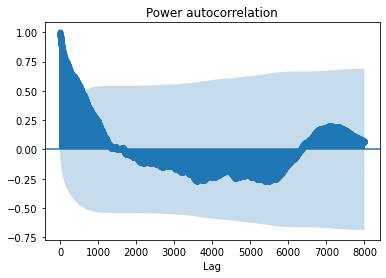

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
fig = plot_acf(raw_data['Power'].values, lags=8000);
ax = fig.get_axes()[0]
ax.set_xlabel('Lag')
ax.set_title('Power autocorrelation');


In [11]:
from scipy.spatial.transform import Rotation as R
r = R.from_euler('z', raw_data['HDG'], degrees=True)
df = pd.DataFrame(index=raw_data.index)
df['u'] = raw_data['V']  ## Assuming no drift
df['v'] = 0  ## Assuming no drift
df['w'] = 0  ## Assuming no drift

df[['dX','dY','dZ']] = r.apply(df)
df[['X','Y','Z']] = df[['dX','dY','dZ']].cumsum()


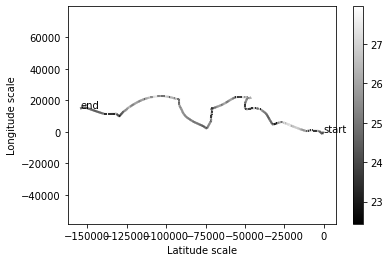

In [12]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = df['Y'].values
y = df['X'].values
dydx = df['u'].values

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots()

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='gray', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)
ax.set_xlim(df['Y'].min(),df['Y'].max())
ax.set_ylim(df['X'].min(),df['X'].max())

ax.annotate('start',xy=df.iloc[0][['Y','X']])
ax.annotate('end',xy=df.iloc[-1][['Y','X']])
ax.axis('equal')
ax.set_xlabel('Latitude scale')
ax.set_ylabel('Longitude scale');

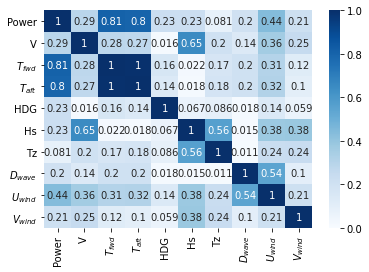

In [13]:
corr = plotable_dataframe(raw_data.corr().abs())

ax = sns.heatmap(corr, vmin=0, vmax=1, yticklabels=corr.index, cmap='Blues', annot=True)
fig = ax.get_figure()

## transform

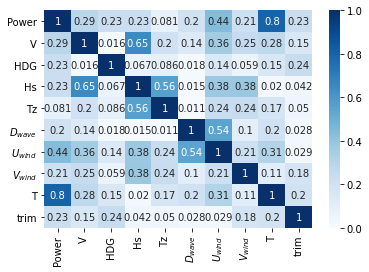

In [14]:
data = transform(raw_data=raw_data)

corr = plotable_dataframe(data.corr().abs())

ax = sns.heatmap(corr, vmin=0, vmax=1, yticklabels=corr.index, cmap='Blues', annot=True)
fig = ax.get_figure()

<AxesSubplot:>

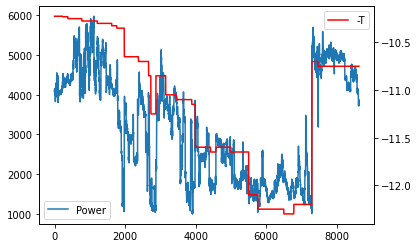

In [15]:
fig,ax=plt.subplots()

data_ = data.copy()
data_.plot(y='Power', ax=ax)
ax2 = ax.twinx()
data_['-T'] = -data_['T']
data_.plot(y='-T', style='r-', ax=ax2)


## Extend data

In [17]:
data_extended = extend(data=data)

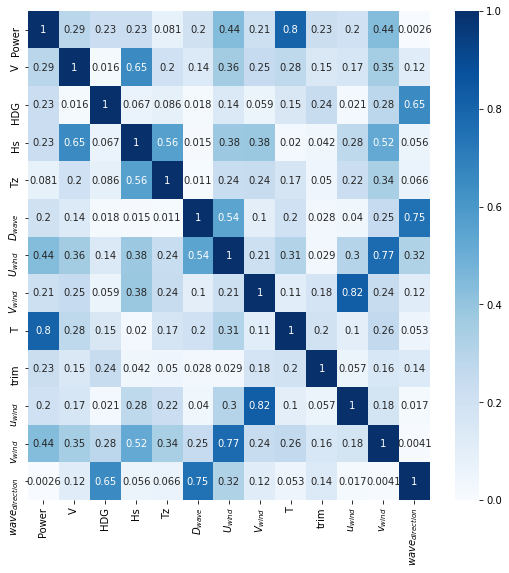

In [18]:
corr = plotable_dataframe(data_extended.corr().abs())
fig,ax = plt.subplots()
fig.set_size_inches(9,9)
ax = sns.heatmap(corr, vmin=0, vmax=1, yticklabels=corr.index, cmap='Blues', annot=True, ax=ax)


In [19]:
data_extended.to_csv('../data/processed/data_extended.csv')